Это ДЗ, условия которого взяты из: [этого ноутбука](../deep_crossentropy_method.ipynb).
А именно:

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


## Что было сделано:
    - Я добавил n_rollouts - сколько раз одна политика играется. В целом 12-ти хватило для достижения положительного reward-а.
    - За счёт усреднения мы понизили фактор попадания "рандомно-везучей" политики в элитные. И наш алгоритм стал корректно решать большее число игровых ситуаций, а не просто забивать на них.


In [ ]:
!pip install tqdm scikit-learn numpy scipy gymnasium matplotlib

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("Taxi-v3", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")

In [ ]:
def initialize_policy(n_states, n_actions):
    policy = np.full((n_states, n_actions), 1 / n_actions)

    return policy


policy = initialize_policy(n_states, n_actions)
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1.0 / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)


In [ ]:
def generate_session(env, policy, t_max=10 ** 4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward


In [ ]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]


In [7]:
from itertools import chain


def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = list(chain.from_iterable(
        states for (states, reward) in zip(states_batch, rewards_batch) if reward > reward_threshold
    ))
    elite_actions = list(chain.from_iterable(
        actions for (actions, reward) in zip(actions_batch, rewards_batch) if reward > reward_threshold
    ))

    return elite_states, elite_actions


In [ ]:
states_batch = [
    [1, 2, 3],  # game1
    [4, 2, 0, 2],  # game2
    [3, 1],  # game3
]

actions_batch = [
    [0, 2, 4],  # game1
    [3, 2, 0, 1],  # game2
    [3, 3],  # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")


In [ ]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    total_visits = new_policy.sum(axis=1, keepdims=True)  # (n_states, 1)
    # Если состояние посещалось: делим счётчики на сумму → вероятности
    # Если не посещалось: сумма = 0 → избежим деления на 0
    with np.errstate(divide='ignore', invalid='ignore'):
        normalized = new_policy / total_visits  # где total_visits > 0 — ок, где 0 — будет nan

    # Заменяем nan (непосещённые состояния) на равномерное распределение
    uniform_prob = 1.0 / n_actions
    new_policy = np.where(total_visits > 0, normalized, uniform_prob)

    return new_policy


In [ ]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy
).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0
), "Your new policy can't have negative action probabilities"
assert np.allclose(
    new_policy.sum(axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")


In [ ]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +990]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


In [ ]:
n_sessions = 50  # sample this many sessions
n_rollouts = 12  # Сколько раз играем одной стратегией для усреднения результата
percentile = 70  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1
policy = initialize_policy(n_states, n_actions)
log = []
%matplotlib inline
for i in range(100):
    sessions = []
    %time
    for _ in range(n_sessions):
        rollouts = [generate_session(env, policy) for __ in range(n_rollouts)]
        states_batch, actions_batch, rewards = zip(*rollouts)
        mean_reward = np.mean(rewards)
        all_states = [s for states_list in states_batch for s in states_list]
        all_actions = [a for actions_list in actions_batch for a in actions_list]
        sessions.append((all_states, all_actions, mean_reward))

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    show_progress(rewards_batch, log, percentile)



# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.


* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.

__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.


### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.


## LunarLander - дискретный

In [ ]:
!pip install Box2D

In [ ]:
!pip install "gymnasium[box2d]"

In [ ]:
import numpy as np
print(np.__version__)


In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118



In [ ]:
!pip uninstall pandas
!pip install pandas

In [ ]:

import pandas as pd

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
True
NVIDIA GeForce GTX 1650


In [2]:
def generate_session_for_agent(env, agent, scaler, t_max=10000):
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()
    s_scaled = scaler.transform([s])

    for t in range(t_max):
        probs = agent.predict_proba(s_scaled)[0]
        assert probs.shape == (env.action_space.n,), "Probabilities shape mismatch"

        a = np.random.choice(env.action_space.n, p=probs)

        new_s, r, terminated, truncated, _ = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

        s_scaled = scaler.transform([s])

    return states, actions, total_reward


In [3]:
from sklearn.neural_network import MLPClassifier
import gymnasium as gym
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


env = gym.make("LunarLander-v3",
               continuous=False,
               gravity=-10.0,
               enable_wind=False,
               wind_power=15.0,
               turbulence_power=1.5,
               render_mode='rgb_array')

n_actions = env.action_space.n  # 4 действия: ничего, влево, вправо, основной двигатель
#Взято из deep_crossentropy. И там итам - задача баланса. +- похоже.

agent = MLPClassifier(
    hidden_layer_sizes=(42, 42),
    activation="tanh",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=1,
    warm_start=True
)
scaler = StandardScaler()


C:\Users\skif1\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [4]:
states_for_scaler = []
s, _ = env.reset()
states_for_scaler.append(s)
for _ in range(1000):  # собираем 1000 состояний
    a = env.action_space.sample()  # случайное действие
    s, _, done, _, _ = env.step(a)
    states_for_scaler.append(s)
    if done:
        s, _ = env.reset()
        states_for_scaler.append(s)

scaler.fit(states_for_scaler)

,copy,True
,with_mean,True
,with_std,True


In [5]:
s, _ = env.reset()
s_scaled = scaler.transform([s])

agent.partial_fit(
    [s_scaled[0]] * n_actions,  # масштабированное состояние
    range(n_actions),
    classes=range(n_actions)
)

,hidden_layer_sizes,"(42, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.01
,power_t,0.5
,max_iter,1
,shuffle,True
,random_state,None


In [6]:
from IPython.display import clear_output


def show_progress_fixed(rewards_batch, log, percentile):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """
    min_reward = min(rewards_batch) - 12
    max_reward = max(rewards_batch) + 12
    reward_range = [min_reward, max_reward]
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


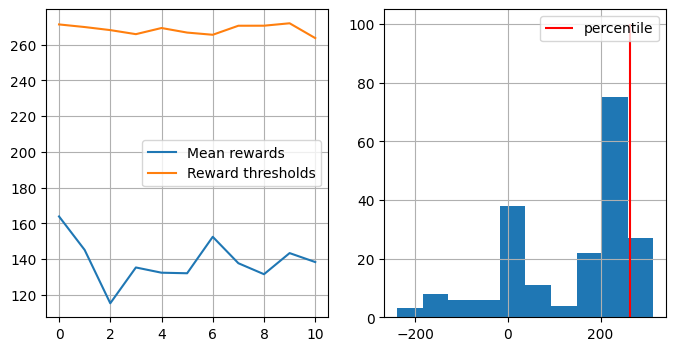

KeyboardInterrupt: 

In [18]:
import numpy as np
log = []
n_sessions = 200  # sample this many sessions
n_rollouts = 1  # Сколько раз играем одной стратегией для усреднения результата
percentile = 70  # discard this percentage of sessions with lowest rewards
for i in range(222):
    interactive_percentile = percentile
    sessions = []
    for _ in range(n_sessions):
        rollouts = [generate_session_for_agent(env, agent, scaler) for __ in range(n_rollouts)]
        _, _, rewards = zip(*rollouts)
        mean_reward = np.mean(rewards)
        all_states = [s for s, _, _ in rollouts]
        all_actions = [a for _, a, _ in rollouts]
        sessions.append((all_states, all_actions, mean_reward))


    states_batch, actions_batch, rewards_batch = zip(*sessions)
    if max(rewards_batch) > 200:
        interactive_percentile = 90
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, interactive_percentile)
        x = np.concatenate(elite_states)
        y = np.concatenate(elite_actions)
        scaler.partial_fit(x)
        x_scaled = scaler.transform(x)
        for i in range(12):
            agent.partial_fit(x_scaled, y)
    else:
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, interactive_percentile)
        x = np.concatenate(elite_states)
        y = np.concatenate(elite_actions)
        scaler.partial_fit(x)
        x_scaled = scaler.transform(x)
        agent.partial_fit(x_scaled, y)


    if max(rewards_batch) > 200:
        print("Успех! Агент научился садиться!")

    show_progress_fixed(rewards_batch, log, interactive_percentile)

In [20]:
import sys
import subprocess
import imageio
import numpy as np
from IPython.display import HTML, display
import base64
import os
from PIL import Image

def resize_frame(frame, target_width=608, target_height=400):
    return np.array(Image.fromarray(frame).resize((target_width, target_height), Image.Resampling.LANCZOS))

def record_and_display_agent(env, agent, scaler, filename="lander_final.mp4", fps=30):
    frames = []
    obs, _ = env.reset()
    done = False

    while not done:
        obs_scaled = scaler.transform([obs])
        action = agent.predict(obs_scaled)[0]
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        frame = env.render()
        frame_resized = resize_frame(frame, target_width=608, target_height=400)
        frames.append(frame_resized)

    # Сохраняем видео
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Видео сохранено: {filename}")

    try:
        video = open(filename, "rb").read()
        video_encoded = base64.b64encode(video).decode('ascii')
        html = f'''
        <video width="400" controls autoplay loop>
            <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
            Your browser does no t support the video tag.
        </video>
        '''
        display(HTML(html))
    except Exception as e:
        print(f"Не удалось встроить видео: {e}")

    try:
        if os.name == 'nt':
            os.startfile(filename)
        elif sys.platform == 'darwin':
            subprocess.run(['open', filename])
        else:
            subprocess.run(['xdg-open', filename])
    except Exception as e:
        print(f"Не удалось открыть видео системой: {e}")

# Вызов
record_and_display_agent(env, agent, scaler)


Видео сохранено: lander_final.mp4


# Mopuntain Car - continous.